# **Import important packages**

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! pip install emoji
!pip install simpletransformers

In [4]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from nltk.util import ngrams
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


In [7]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
stop_words = set(stopwords.words('english'))

In [9]:
df1 = pd.read_csv('https://drive.usercontent.google.com/download?id=1f2x1SY-p0I-nIH8SmkLgJwPFpj7nRnCz&export=download&authuser=1&confirm=t&uuid=4c242c4b-8a66-4b1d-b681-05c7ad4c7f38&at=APZUnTVEMn1LoxLOK0diZfisUv2K:1721305872963')

In [10]:
df1

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [11]:
# Count the number of NaN values before dropping them
num_nan_values_before = df1['clean_text'].isna().sum()

#show the number of NaN values in the dataset
print(num_nan_values_before)

# Drop NaN values from 'clean_text' column
df1 = df1.dropna(subset=['clean_text'])


4


there is 4 nan records in the dataset by they had been droped from the dataset

# **Count the presence of the NaN values, stop words, punchuation, URLs and emojis in the dataset**

In [12]:
# Function to count links
def count_links(text):
    if pd.isna(text):
        return 0
    return len(re.findall(r'https?://\S+|www\.\S+', str(text)))

# Function to count emojis
def count_emojis(text):
    if pd.isna(text):
        return 0
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F700-\U0001F77F"
        u"\U0001F780-\U0001F7FF"
        u"\U0001F800-\U0001F8FF"
        u"\U0001F900-\U0001F9FF"
        u"\U0001FA00-\U0001FA6F"
        u"\U0001FA70-\U0001FAFF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        re.UNICODE,
    )
    return len(emoji_pattern.findall(str(text)))

# Function to check for punctuation
def has_punctuation(text):
    if pd.isna(text):
        return False
    punctuation_set = set(string.punctuation)
    return any(char in punctuation_set for char in str(text))

# Apply functions to the DataFrame
df1['num_links'] = df1['clean_text'].apply(count_links)
df1['num_emojis'] = df1['clean_text'].apply(count_emojis)
df1['has_punctuation'] = df1['clean_text'].apply(has_punctuation)

# Count statistics
num_links = df1['num_links'].sum()
num_emojis = df1['num_emojis'].sum()
num_nan_values = df1['clean_text'].isna().sum()
num_text_with_punctuation = df1['has_punctuation'].sum()

# Display the statistics
print(f"Number of links in the dataset: {num_links}")
print(f"Number of emojis in the dataset: {num_emojis}")
print(f"Number of NaN values in the dataset: {num_nan_values}")
print(f"Number of texts with punctuation: {num_text_with_punctuation}")

# Optionally, drop the helper columns used for counting
df1.drop(columns=['num_links', 'num_emojis', 'has_punctuation'], inplace=True)


<ipython-input-12-2468701d38e5>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['num_links'] = df1['clean_text'].apply(count_links)
<ipython-input-12-2468701d38e5>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['num_emojis'] = df1['clean_text'].apply(count_emojis)


Number of links in the dataset: 0
Number of emojis in the dataset: 2599
Number of NaN values in the dataset: 0
Number of texts with punctuation: 290


<ipython-input-12-2468701d38e5>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['has_punctuation'] = df1['clean_text'].apply(has_punctuation)
<ipython-input-12-2468701d38e5>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(columns=['num_links', 'num_emojis', 'has_punctuation'], inplace=True)


In [13]:
chat_word = {
    'AFAIK': 'As Far As I Know',
    'AFK': 'Away From Keyboard',
    'ASAP': 'As Soon As Possible',
    'ATK': 'At The Keyboard',
    'ATM': 'At The Moment',
    'A3': 'Anytime, Anywhere, Anyplace',
    'BAK': 'Back At Keyboard',
    'BBL': 'Be Back Later',
    'BBS': 'Be Back Soon',
    'BFN': 'Bye For Now',
    'B4N': 'Bye For Now',
    'BRB': 'Be Right Back',
    'BRT': 'Be Right There',
    'BTW': 'By The Way',
    'B4': 'Before',
    'CU': 'See You',
    'CUL8R': 'See You Later',
    'CYA': 'See You',
    'FAQ': 'Frequently Asked Questions',
    'FC': 'Fingers Crossed',
    'FWIW': "For What It's Worth",
    'FYI': 'For Your Information',
    'GAL': 'Get A Life',
    'GG': 'Good Game',
    'GN': 'Good Night',
    'GMTA': 'Great Minds Think Alike',
    'GR8': 'Great!',
    'G9': 'Genius',
    'IC': 'I See',
    'ICQ': 'I Seek you (also a chat program)',
    'ILU': 'ILU: I Love You',
    'IMHO': 'In My Honest/Humble Opinion',
    'IMO': 'In My Opinion',
    'IOW': 'In Other Words',
    'IRL': 'In Real Life',
    'KISS': 'Keep It Simple, Stupid',
    'LDR': 'Long Distance Relationship',
    'LMAO': 'Laugh My A.. Off',
    'LOL': 'Laughing Out Loud',
    'LTNS': 'Long Time No See',
    'L8R': 'Later',
    'MTE': 'My Thoughts Exactly',
    'M8': 'Mate',
    'NRN': 'No Reply Necessary',
    'OIC': 'Oh I See',
    'PITA': 'Pain In The A..',
    'PRT': 'Party',
    'PRW': 'Parents Are Watching',
    'QPSA?': 'Que Pasa?',
    'ROFL': 'Rolling On The Floor Laughing',
    'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
    'ROTFLMAO': 'Rolling On The Floor Laughing My A.. Off',
    'SK8': 'Skate',
    'STATS': 'Your sex and age',
    'ASL': 'Age, Sex, Location',
    'THX': 'Thank You',
    'TTFN': 'Ta-Ta For Now!',
    'TTYL': 'Talk To You Later',
    'U': 'You',
    'U2': 'You Too',
    'U4E': 'Yours For Ever',
    'WB': 'Welcome Back',
    'WTF': 'What The F...',
    'WTG': 'Way To Go!',
    'WUF': 'Where Are You From?',
    'W8': 'Wait...',
    '7K': 'Sick:-D Laugher',
    'TFW': 'That feeling when',
    'MFW': 'My face when',
    'MRW': 'My reaction when',
    'IFYP': 'I feel your pain',
    'TNTL': 'Trying not to laugh',
    'JK': 'Just kidding',
    'IDC': "I don't care",
    'ILY': 'I love you',
    'IMU': 'I miss you',
    'ADIH': 'Another day in hell',
    'ZZZ': 'Sleeping, bored, tired',
    'WYWH': 'Wish you were here',
    'TIME': 'Tears in my eyes',
    'BAE': 'Before anyone else',
    'FIMH': 'Forever in my heart',
    'BSAAW': 'Big smile and a wink',
    'BWL': 'Bursting with laughter',
    'BFF': 'Best friends forever',
    'CSL': "Can't stop laughing"
}

def count_chat_words(text):
    words = text.split()
    return sum(1 for word in words if word in chat_word)

df1['num_chat_words'] = df1['clean_text'].apply(count_chat_words)
total_chat_words = df1['num_chat_words'].sum()
print(f"Total number of chat words in the dataset: {total_chat_words}")
df1.drop(columns=['num_chat_words'], inplace=True)


Total number of chat words in the dataset: 0


<ipython-input-13-364a14d11aa3>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['num_chat_words'] = df1['clean_text'].apply(count_chat_words)
<ipython-input-13-364a14d11aa3>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(columns=['num_chat_words'], inplace=True)


In [14]:
# Function to count stop words
def count_stop_words(text):
    words = text.split()
    return sum(1 for word in words if word.lower() in stop_words)

# Apply the function to the DataFrame
df1['num_stop_words'] = df1['clean_text'].apply(count_stop_words)

# Sum up the counts to get the total number of stop words in the dataset
total_stop_words = df1['num_stop_words'].sum()

print(f"Total number of stop words in the dataset: {total_stop_words}")

# Optionally, drop the helper column used for counting
df1.drop(columns=['num_stop_words'], inplace=True)

Total number of stop words in the dataset: 920956


<ipython-input-14-d9a4ab9d545c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['num_stop_words'] = df1['clean_text'].apply(count_stop_words)
<ipython-input-14-d9a4ab9d545c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(columns=['num_stop_words'], inplace=True)


the above results shows that the dataset contains emojies and punctations but does not contains any links or chat words. this info will help us to design the right data cleaning and preprocessing pipeline for the dataset

#**Data cleaning and preprocessing**

In [15]:
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Function to replace emojis with their descriptions
def replace_emojis(text):
    return emoji.demojize(text)

# Function to remove stop words
def remove_stop_words(text):
    words = nltk.word_tokenize(text)
    return ' '.join(word for word in words if word.lower() not in stop_words)

# Function to perform stemming
def apply_stemming(text):
    words = nltk.word_tokenize(text)
    return ' '.join(stemmer.stem(word) for word in words)

# Function to perform lemmatization
def apply_lemmatization(text):
    words = nltk.word_tokenize(text)
    return ' '.join(lemmatizer.lemmatize(word) for word in words)

# Function to preprocess text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Replace emojis with text descriptions
    text = replace_emojis(text)
    # Remove stop words
    text = remove_stop_words(text)
    # Perform stemming
    text = apply_stemming(text)
    # Perform lemmatization
    text = apply_lemmatization(text)
    return text

# Apply preprocessing to the DataFrame
df1['clean_text'] = df1['clean_text'].apply(preprocess_text)

<ipython-input-15-cb2ceff842a5>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['clean_text'] = df1['clean_text'].apply(preprocess_text)


In [16]:
df1.head()

,clean_text,category
0,modi promis “ minimum govern maximum govern ” ...,-1.0
1,talk nonsens continu drama vote modi,0.0
2,say vote modi welcom bjp told rahul main campa...,1.0
3,ask support prefix chowkidar name modi great s...,1.0
4,answer among power world leader today trump pu...,1.0


convert labels to 1, 2, 3

In [17]:
# Convert category labels
df1['category'] = df1['category'].replace({-1.0: 0, 0.0: 1, 1.0: 2})

<ipython-input-17-3c3cbcca38c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['category'] = df1['category'].replace({-1.0: 0, 0.0: 1, 1.0: 2})


In [18]:
# Drop NaN values from 'category' column
df1 = df1.dropna(subset=['category'])

In [19]:
df1['category'] = df1['category'].astype(int)

<ipython-input-19-63d7b4347b32>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['category'] = df1['category'].astype(int)


In [20]:
df1

,clean_text,category
0,modi promis “ minimum govern maximum govern ” ...,0
1,talk nonsens continu drama vote modi,1
2,say vote modi welcom bjp told rahul main campa...,2
3,ask support prefix chowkidar name modi great s...,2
4,answer among power world leader today trump pu...,2
...,...,...
162975,456 crore paid neerav modi recov congress lead...,0
162976,dear r terrorist payal gawar modi kill 1000 pl...,0
162977,cover interact forum left,1
162978,big project came india modi dream project happ...,1


# **Exploring the dataset using statistics**

<ipython-input-21-dd7e1e68c139>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='category', data=df1, palette='viridis')


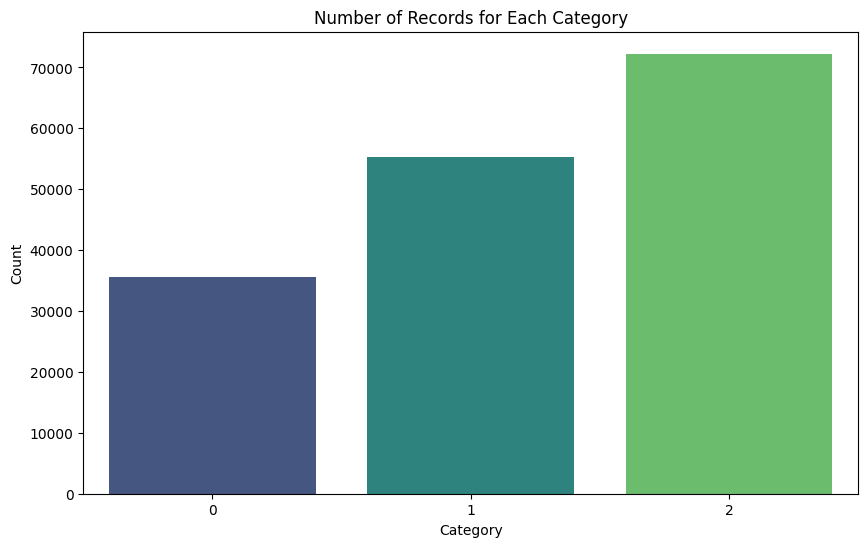

In [21]:
# Plot the number of records for each category
plt.figure(figsize=(10, 6))
sns.countplot(x='category', data=df1, palette='viridis')
plt.title('Number of Records for Each Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks([0, 1, 2], ['0', '1', '2'])
plt.show()

The above graph shows that the dataset is not balanced that may make the model baised to the most frequent categories.
If the results are not good we will need to solve this problem using over/under sampling, data Augmentation.

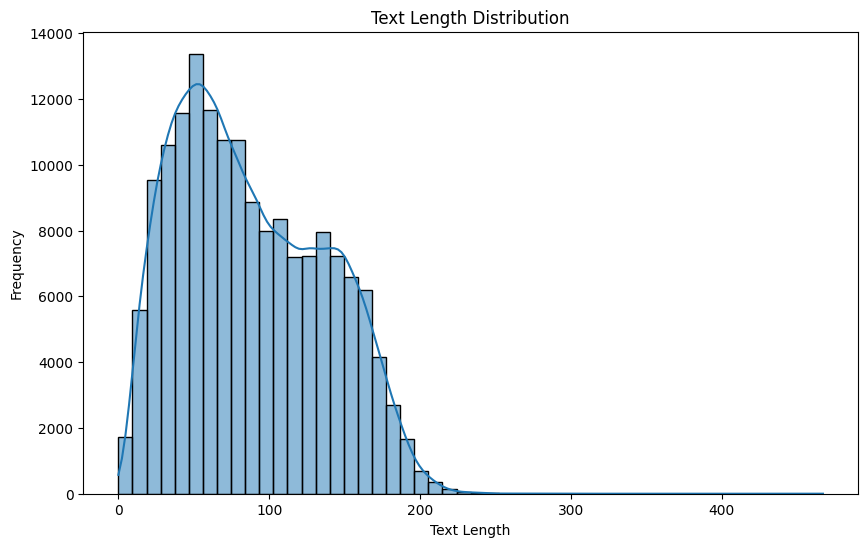

In [22]:
# Text Length Distribution
df1['text_length'] = df1['clean_text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df1['text_length'], bins=50, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


The sentences length is between 0-200 words and the average is 50 words

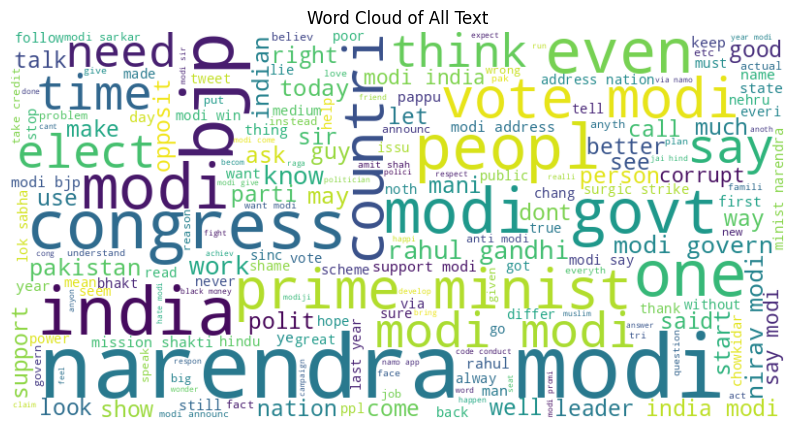

In [23]:
# Word Cloud
all_text = ' '.join(df1['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Text')
plt.show()

# **Split the dataset**

In [24]:
# First split: 75% training, 25% remaining
train_df, temp_df = train_test_split(df1, test_size=0.25, random_state=42)

# Second split: 40% of the remaining 25% for validation (0.4 * 0.25 = 0.10) and 60% for test (0.6 * 0.25 = 0.15)
val_df, test_df = train_test_split(temp_df, test_size=0.6, random_state=42)

# Print the shapes of train_df, val_df, and test_df
print("Train DataFrame shape:", train_df.shape)
print("Validation DataFrame shape:", val_df.shape)
print("Test DataFrame shape:", test_df.shape)

# Combine training and validation sets for final training
train_val_df = pd.concat([train_df, val_df])


Train DataFrame shape: (122226, 3)
Validation DataFrame shape: (16297, 3)
Test DataFrame shape: (24446, 3)


Configring, Training and testing the model

# **Training BERT Model**

In [ ]:


# Print the shapes of train_val_df and test_df
print("Train + Validation DataFrame shape:", train_val_df.shape)
print("Test DataFrame shape:", test_df.shape)

# Logging setup
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=2,
                                output_dir='/content/drive/MyDrive/outputs/',
                                overwrite_output_dir=True,
                                evaluate_during_training=True,
                                save_best_model=True)

# Create a ClassificationModel
model = ClassificationModel(
    'bert',
    'asafaya/bert-base-arabic',
    num_labels=3,
    args=model_args
)

Train + Validation DataFrame shape: (138523, 3)
Test DataFrame shape: (24446, 3)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-arabic and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/334k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# Train the model on the combined training and validation set
model.train_model(train_val_df, eval_df=val_df)

# Evaluate the model on the test set
result, model_outputs, wrong_predictions = model.eval_model(test_df)

# Print evaluation results
print("Evaluation results:", result)

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/277 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/17316 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/32 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/32 [00:00<?, ?it/s]

Running Epoch 2 of 2:   0%|          | 0/17316 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/48 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluation results: {'mcc': 0.7326295356050673, 'eval_loss': 0.519401749238676}


In [ ]:
result

{'mcc': 0.7326295356050673, 'eval_loss': 0.519401749238676}

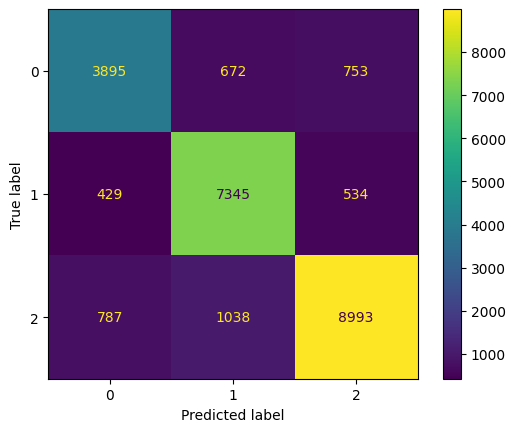

In [ ]:
prediction= model_outputs.argmax(axis=1)
true_labels = test_df['category'].values
ConfusionMatrixDisplay.from_predictions(true_labels, prediction)
plt.show()

#**Training Bigram-logistic regression model**

In [ ]:
# Vectorize the text using TfidfVectorizer with trigrams
vectorizer = TfidfVectorizer(ngram_range=(2, 2))
X_train = vectorizer.fit_transform(train_val_df['clean_text'])
X_test = vectorizer.transform(test_df['clean_text'])

y_train = train_val_df['category']
y_test = test_df['category']

In [ ]:
# Train a classifier (Logistic Regression)
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = classifier.predict(X_test)

# Print evaluation results
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.36      0.48      5320
           1       0.62      0.65      0.63      8308
           2       0.64      0.77      0.70     10818

    accuracy                           0.64     24446
   macro avg       0.66      0.59      0.60     24446
weighted avg       0.65      0.64      0.63     24446



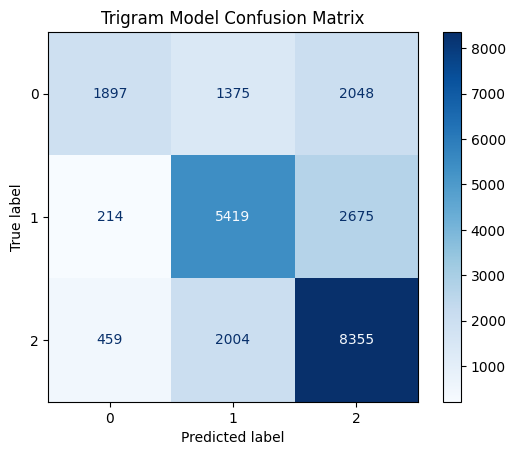

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

disp.plot(cmap=plt.cm.Blues)
plt.title('Trigram Model Confusion Matrix')
plt.show()

#**Training Trigram-logistic regression model**

In [ ]:
# Vectorize the text using TfidfVectorizer with trigrams
vectorizer = TfidfVectorizer(ngram_range=(3, 3))
X_train = vectorizer.fit_transform(train_val_df['clean_text'])
X_test = vectorizer.transform(test_df['clean_text'])

y_train = train_val_df['category']
y_test = test_df['category']

In [ ]:
# Train a classifier (Logistic Regression)
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = classifier.predict(X_test)

# Print evaluation results
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.16      0.27      5320
           1       0.56      0.34      0.42      8308
           2       0.50      0.85      0.63     10818

    accuracy                           0.53     24446
   macro avg       0.61      0.45      0.44     24446
weighted avg       0.58      0.53      0.48     24446



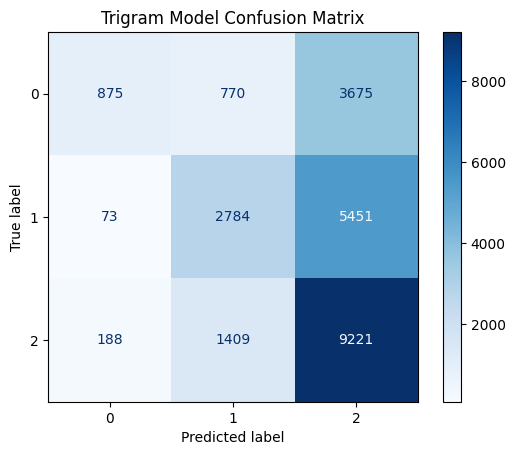

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

disp.plot(cmap=plt.cm.Blues)
plt.title('Trigram Model Confusion Matrix')
plt.show()

Training Logistic Regression...
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.80      0.70      0.75      5320
           1       0.85      0.81      0.83      8308
           2       0.81      0.88      0.84     10818

    accuracy                           0.82     24446
   macro avg       0.82      0.80      0.81     24446
weighted avg       0.82      0.82      0.82     24446



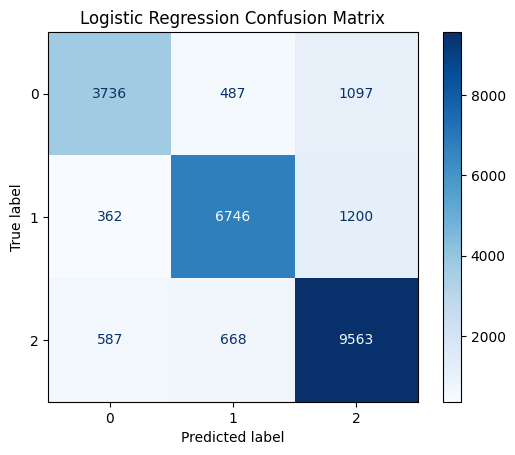

Training Multinomial Naive Bayes...
Classification Report for Multinomial Naive Bayes:
               precision    recall  f1-score   support

           0       0.95      0.08      0.14      5320
           1       0.87      0.24      0.38      8308
           2       0.49      0.98      0.65     10818

    accuracy                           0.53     24446
   macro avg       0.77      0.43      0.39     24446
weighted avg       0.72      0.53      0.45     24446



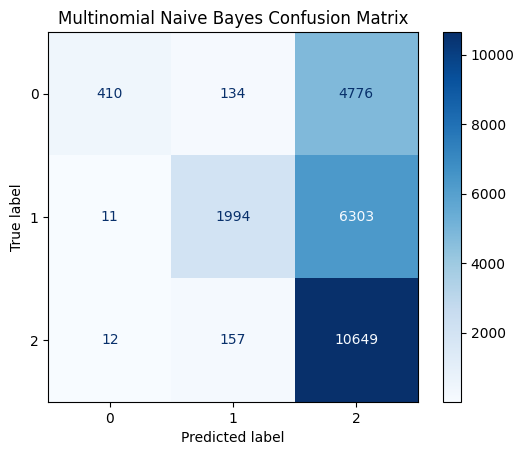

Training K-Nearest Neighbors...


In [ ]:
# Vectorize the text using TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 3))  # Using unigrams, bigrams, and trigrams
X_train = vectorizer.fit_transform(train_val_df['clean_text'])
X_test = vectorizer.transform(test_df['clean_text'])

y_train = train_val_df['category']
y_test = test_df['category']

# Define a dictionary of models to test
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Multinomial Naive Bayes": MultinomialNB(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Classification Report for {name}:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{name} Confusion Matrix')
    plt.show()

In [25]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_val_df['clean_text'])

X_train = tokenizer.texts_to_sequences(train_val_df['clean_text'])
X_test = tokenizer.texts_to_sequences(test_df['clean_text'])

X_train = pad_sequences(X_train, maxlen=100)
X_test = pad_sequences(X_test, maxlen=100)

y_train = train_val_df['category']
y_test = test_df['category']

In [26]:
# Encode labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [27]:
# Define the model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [29]:
# Train the model
history = model.fit(X_train, y_train, epochs=2, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {accuracy}')

Epoch 1/2
2165/2165 [==============================] - 802s 370ms/step - loss: 0.4778 - accuracy: 0.8226 - val_loss: 0.4120 - val_accuracy: 0.8538
Epoch 2/2
764/764 [==============================] - 35s 46ms/step - loss: 0.3958 - accuracy: 0.8594
Test Accuracy: 0.8593634963035583


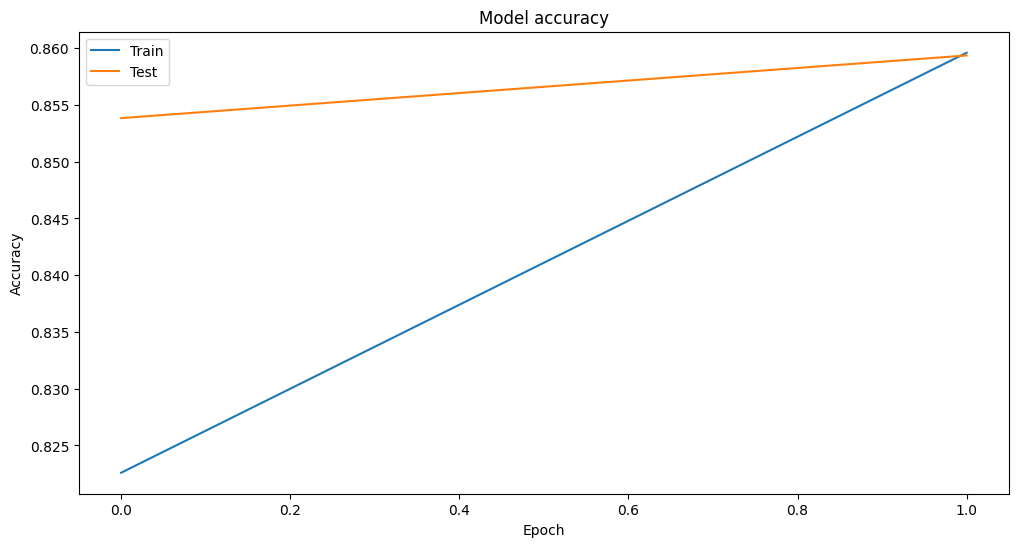

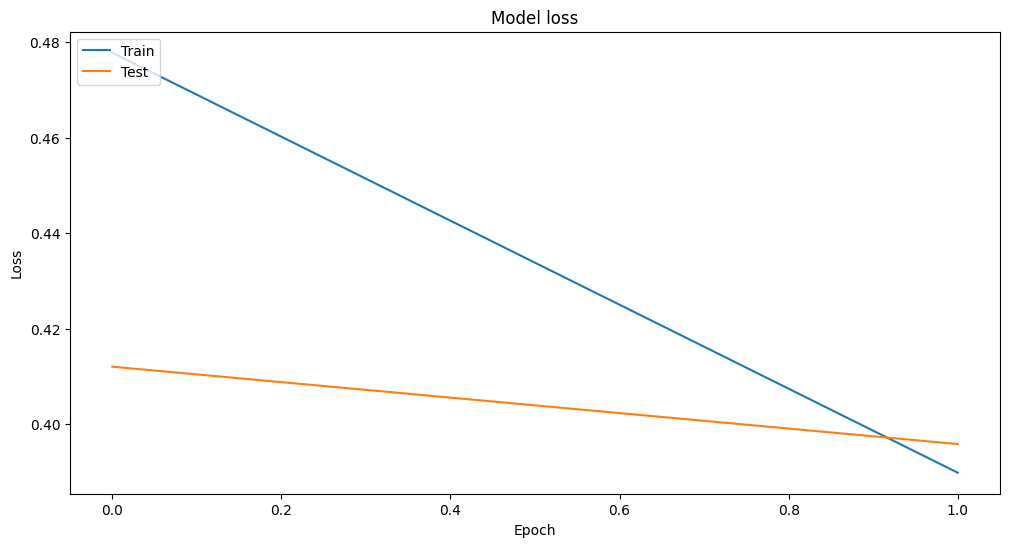

In [30]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()